# Vivado Flow

We're going to train a fully connected neural network with QKeras on the jet tagging dataset and run it baremetal on Zynq-class boards (ZCU106, Ultra96, Pynq-Z1, MiniZed).

## Setup

Let's import the libraries, call the magic functions, and setup the environment variables.

In [1]:
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects

import numpy as np

import hls4ml

from callbacks import all_callbacks

%matplotlib inline

import os
os.environ['PATH'] = '/extra/tools/Xilinx/Vivado/2019.1/bin:' + os.environ['PATH']

def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')

-----------------------------------
Xilinx Vivado HLS is in the PATH
-----------------------------------


## Load the dataset

This is a lot like the previous notebooks, so we will go through quickly.

First, we fetch the dataset from OpenML, do the normalization and make a train and test split.

We save the test dataset to files so that we can use them later.

In [2]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)
classes = le.classes_

os.makedirs('npy', exist_ok=True)
np.save('npy/y_test.npy', y_test)
np.save('npy/X_test.npy', X_test)
np.save('npy/classes.npy', le.classes_, allow_pickle=True)

## Model training
Our favourite 3 hidden-layer model. 6 bit quantizers everywhere.

In [3]:
model = Sequential()
model.add(QDense(8, input_shape=(16,), name='fc1',
                 kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(QActivation(activation=quantized_relu(6), name='relu1'))
model.add(QDense(8, name='fc2',
                 kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(QActivation(activation=quantized_relu(6), name='relu2'))
model.add(QDense(8, name='fc3',
                 kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(QActivation(activation=quantized_relu(6), name='relu3'))
model.add(QDense(5, name='output',
                 kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

## Prune
Because why not?

In [4]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

Instructions for updating:
Please use `layer.add_weight` method instead.


## Train

In [5]:
train = True
#not os.path.exists('model/KERAS_check_best_model.h5')
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model')
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save('model/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model('model/KERAS_check_best_model.h5', custom_objects=co)

Epoch 1/30
  1/487 [..............................] - ETA: 0s - loss: 1.5917 - accuracy: 0.2627WARNING:tensorflow:From /home/giuseppe/miniconda3/envs/hls4ml-tutorial-cu/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
485/487 [============================>.] - ETA: 0s - loss: 1.5331 - accuracy: 0.2997
***callbacks***
saving losses to model/losses.log

Epoch 00001: val_loss improved from inf to 1.48756, saving model to model/KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 1.48756, saving model to model/KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model/KERAS_check_model_last.h5

Epoch 00001: saving model to model/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 4ms/step - loss: 1.5329 - accuracy: 0.2999 

Epoch 14/30
473/487 [============================>.] - ETA: 0s - loss: 1.3112 - accuracy: 0.5151
***callbacks***
saving losses to model/losses.log

Epoch 00014: val_loss did not improve from 1.30622

Epoch 00014: val_loss did not improve from 1.30622

Epoch 00014: saving model to model/KERAS_check_model_last.h5

Epoch 00014: saving model to model/KERAS_check_model_last_weights.h5

Epoch 00014: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

***callbacks end***

487/487 [==============================] - 1s 3ms/step - loss: 1.3108 - accuracy: 0.5152 - val_loss: 1.3092 - val_accuracy: 0.5109
Epoch 15/30
467/487 [===========================>..] - ETA: 0s - loss: 1.3067 - accuracy: 0.5180
***callbacks***
saving losses to model/losses.log

Epoch 00015: val_loss did not improve from 1.30622

Epoch 00015: val_loss did not improve from 1.30622

Epoch 00015: saving model to model/KERAS_check_model_last.h5

Epoch 00015: saving model to model/KERAS_check_model_last_weights.h5


Epoch 27/30
484/487 [============================>.] - ETA: 0s - loss: 1.2851 - accuracy: 0.5595
***callbacks***
saving losses to model/losses.log

Epoch 00027: val_loss improved from 1.28701 to 1.28604, saving model to model/KERAS_check_best_model.h5

Epoch 00027: val_loss improved from 1.28701 to 1.28604, saving model to model/KERAS_check_best_model_weights.h5

Epoch 00027: saving model to model/KERAS_check_model_last.h5

Epoch 00027: saving model to model/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 3ms/step - loss: 1.2851 - accuracy: 0.5595 - val_loss: 1.2860 - val_accuracy: 0.5599
Epoch 28/30
477/487 [============================>.] - ETA: 0s - loss: 1.2843 - accuracy: 0.5587
***callbacks***
saving losses to model/losses.log

Epoch 00028: val_loss improved from 1.28604 to 1.28554, saving model to model/KERAS_check_best_model.h5

Epoch 00028: val_loss improved from 1.28604 to 1.28554, saving model to model/KERAS_check_best_mo

## Check accuracy

Do not expect a good accuracy because of the low amount of neurons. I could have done better than this, but as long as it fits both Pynq-Z1 and MiniZed, it is fine with us.

Accuracy: 0.5615542168674699


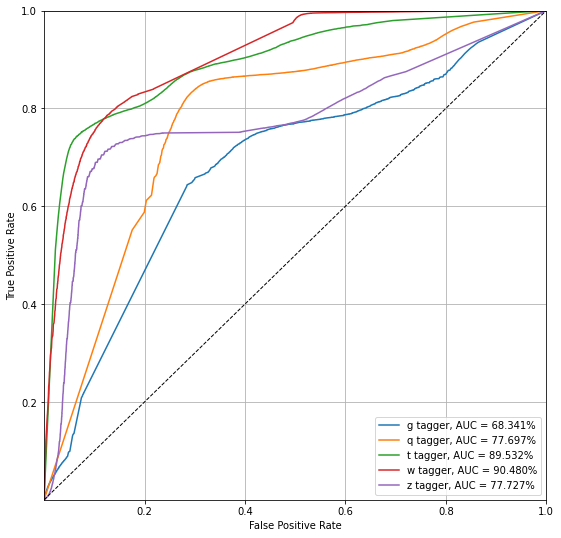

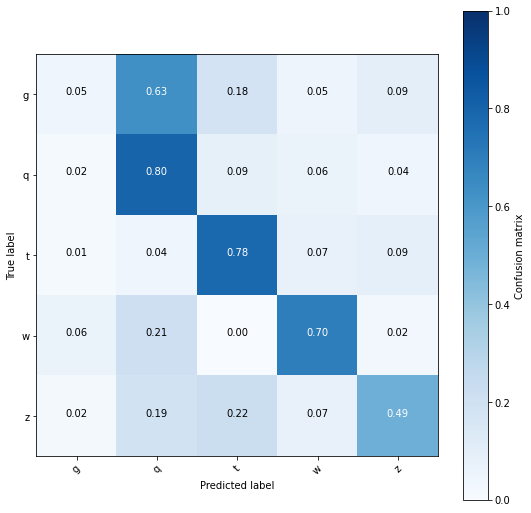

In [6]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import plotting

y_keras = model.predict(X_test)
np.save('npy/y_qkeras.npy', y_keras)

print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))

plt.figure(figsize=(9,9))
_ = plotting.plotMultiClassRoc(y_test, y_keras, classes)

import plotting # Import local package plotting.py
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=np.argmax(y_keras, axis=1))
plt.figure(figsize=(9,9))
_ = plotting.plot_confusion_matrix(cm, le.classes_)

## Make an hls4ml configuration
Notice we're using `Strategy: Resource` for every layer, and `ReuseFactor: 64`. The Programmable Logic (FPGA part) of the Pynq-Z1 SoC is not big compared to VU9P type of parts.

We also use some settings which are good for QKeras.

Notice the `fpga_part:'xc7z020clg400-1'`.

In [7]:
import plotting

hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['Model'] = {}
config['Model']['ReuseFactor'] = 64
config['Model']['Strategy'] = 'Resource'
config['Model']['Precision'] = 'ap_fixed<16,6>'
config['LayerName']['fc1']['ReuseFactor'] = 64
config['LayerName']['fc2']['ReuseFactor'] = 64
config['LayerName']['fc3']['ReuseFactor'] = 64
config['LayerName']['output']['ReuseFactor'] = 64
config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'

print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")

-----------------------------------
Model
  ReuseFactor:       64
  Strategy:          Resource
  Precision:         ap_fixed<16,6>
LayerName
  fc1_input
    Precision
      result:        ap_fixed<16,6>
  fc1
    Precision
      weight:        ap_fixed<7,1>
      bias:          ap_fixed<7,1>
    ReuseFactor:     64
  relu1
    Precision
      result:        ap_fixed<7,1>
    ReuseFactor:     1
  fc2
    Precision
      weight:        ap_fixed<7,1>
      bias:          ap_fixed<7,1>
    ReuseFactor:     64
  relu2
    Precision
      result:        ap_fixed<7,1>
    ReuseFactor:     1
  fc3
    Precision
      weight:        ap_fixed<7,1>
      bias:          ap_fixed<7,1>
    ReuseFactor:     64
  relu3
    Precision
      result:        ap_fixed<7,1>
    ReuseFactor:     1
  output
    Precision
      weight:        ap_fixed<7,1>
      bias:          ap_fixed<7,1>
    ReuseFactor:     64
  softmax
    Precision:       ap_fixed<16,6>
    ReuseFactor:     1
    table_size:      1024
  

## Convert and Compile

In [13]:
## ZCU106
#output_dir='hls/zcu106_prj'
#fpga_part='xczu7ev-ffvc1156-2-e'
 
## Ultra96
#output_dir='hls/ultra96_prj'
#fpga_part='xczu3eg-sbva484-1-e'

## Pynq-Z1
#output_dir='hls/pynqz1_prj'
#fpga_part='xc7z020clg400-1'

## MiniZed
output_dir='hls/minized_prj'
fpga_part='xc7z007sclg225-1'


hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir=output_dir,
                                                       fpga_part=fpga_part)

_ = hls_model.compile()

## Manually Edit the Project

Similarly to the Pynq flow we can generate a project to support the Vivado flow. For the moment we manually edit the hls4ml project (from the `main` branch).

0. Move in the `hls/BOARD_prj` where `BOARD` can be `ultra96`, `pynqz1`, `minized` etc.
   ```
   cd hls/BOARD_prj
   ```

1. Manually edit the file `build_prj.tcl`
   - Set target clock period 10ns

2. Manually edit the file `firmware/nnet_utils/nnet_helpers.h`
   - Change the function `void print_result(...)`
   ```
   #include <limits>
   typedef std::numeric_limits< double > dbl;
   typedef std::numeric_limits< float > flt;
   template<class res_T, size_t SIZE>
   void print_result(res_T result[SIZE], std::ostream &out, bool keep = false) {
       out.precision(flt::max_digits10);
       for(int i = 0; i < SIZE; i++) {
           out << result[i].to_double() << " ";
       }
       out << std::endl;
   }
   ```

3. Manually edit the file `firmware/myproject.cpp`
   - Rename the function `void myproject(...)` to `void myproject_inner(...)`
   - Add `#pragma HLS inline off` to function `void myproject_inner(...)`
   - Comment the line `#pragma HLS INTERFACE ap_vld port=fc1_input,layer13_out`
   - At the bottom of the file add
   ```
   static const unsigned src_depth = N_INPUT_1_1;
   static const unsigned dst_depth = N_LAYER_11;
   void myproject(
       input_t src[N_INPUT_1_1],
       result_t dst[N_LAYER_11],
       unsigned short &const_size_in_1,
       unsigned short &const_size_out_1
   ) {
       #pragma HLS INTERFACE s_axilite port=return bundle=CTRL_BUS
       #pragma HLS INTERFACE m_axi depth=src_depth port=src offset=slave bundle=SRC_BUS
       #pragma HLS INTERFACE m_axi depth=dst_depth port=dst offset=slave bundle=DST_BUS
       #pragma HLS INTERFACE s_axilite port=const_size_in_1 bundle=CTRL_BUS
       #pragma HLS INTERFACE s_axilite port=const_size_out_1 bundle=CTRL_BUS

       //#pragma HLS DATAFLOW

       // Private Local Memories (PLMs)
       input_t src_plm[N_INPUT_1_1];
       result_t dst_plm[N_LAYER_11];

       for (unsigned i = 0; i < N_INPUT_1_1; i++) {
           #pragma HLS unroll
           src_plm[i] = src[i];
       }
       //memcpy(src_plm, src, N_INPUT_1_1*sizeof(unsigned short));

       myproject_inner(src_plm, dst_plm, const_size_in_1, const_size_out_1);

       for (unsigned i = 0; i < N_LAYER_11; i++) {
           #pragma HLS unroll
           dst[i] = dst_plm[i];
       }
       //memcpy(dst, dst_plm, N_LAYER_11*sizeof(unsigned short));
   }
   ```

**===== Do not go beyond here if you did not have manually edited the hls4ml project! =====**

## Prediction and Comparison

(At this point, the C++ code that you have previously edited gets compiled and executed.)


In [14]:
y_hls = hls_model.predict(np.ascontiguousarray(X_test))

print('-----------------------------------')
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))
print('-----------------------------------')

-----------------------------------
Keras  Accuracy: 0.5615542168674699
hls4ml Accuracy: 0.5561987951807229
-----------------------------------


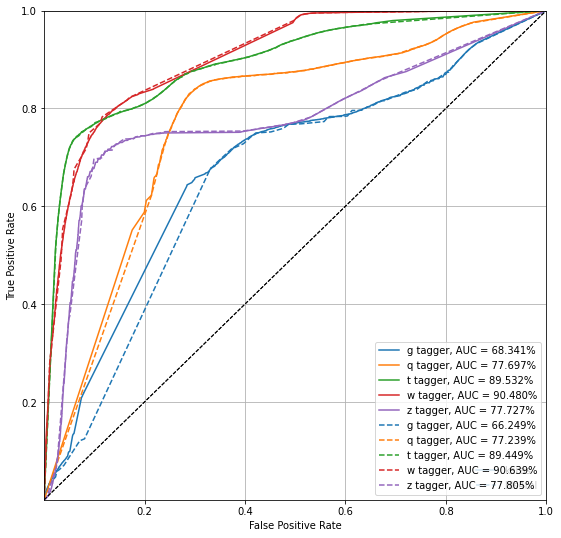

In [15]:
# Enable logarithmic scale on TPR and FPR axes 
logscale_tpr = False # Y axis
logscale_fpr = False # X axis

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.plotMultiClassRoc(y_test, y_keras, classes, logscale_tpr=logscale_tpr, logscale_fpr=logscale_fpr)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.plotMultiClassRoc(y_test, y_hls, classes, logscale_tpr=logscale_tpr, logscale_fpr=logscale_fpr, linestyle='--')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['keras', 'hls4ml'],
            loc='lower right', frameon=False)
_ = ax.add_artist(leg)

## Synthesis

In [16]:
hls_model.build(csim=False,synth=True,export=True)

hls4ml.report.read_vivado_report(output_dir)

Found 1 solution(s) in hls/minized_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Thu Feb  4 10:26:54 2021

* Version:        2019.1 (Build 2552052 on Fri May 24 15:28:33 MDT 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynq
* Target device:  xc7z007s-clg225-1


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |  10.00|     8.750|        1.25|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+---------+
    |  Latency  |  Interval | Pipeline|
    | min | max | min | max |   Type  |
    +-----+-----+-----+-----+---------+
    |  305|  309|  305|  309|   none  |
    +-----+-----+-----+-----+---------+

    + Deta

## Results

See the resource usage for different boards.


```
+-----------------+---------+-------+--------+-------+-----+
|                        PYNQ-Z1                           |
+-----------------+---------+-------+--------+-------+-----+
|Total            |        8|      7|    6089|  13557|    0|
+-----------------+---------+-------+--------+-------+-----+
|Available        |      280|    220|  106400|  53200|    0|
+-----------------+---------+-------+--------+-------+-----+
|Utilization (%)  |        2|      3|       5|     25|    0|
+-----------------+---------+-------+--------+-------+-----+
    +-----+-----+-----+-----+---------+
    |  Latency  |  Interval | Pipeline|
    | min | max | min | max |   Type  |
    +-----+-----+-----+-----+---------+
    |  305|  309|  305|  309|   none  |
    +-----+-----+-----+-----+---------+


+-----------------+---------+-------+--------+-------+----+
|                        MiniZed                          |
+-----------------+---------+-------+-------+-------+-----+
|Total            |        8|      7|   6089|  13557|    0|
+-----------------+---------+-------+-------+-------+-----+
|Available        |      100|     66|  28800|  14400|    0|
+-----------------+---------+-------+-------+-------+-----+
|Utilization (%)  |        8|     10|     21|     94|    0|
+-----------------+---------+-------+-------+-------+-----+
    +-----+-----+-----+-----+---------+
    |  Latency  |  Interval | Pipeline|
    | min | max | min | max |   Type  |
    +-----+-----+-----+-----+---------+
    |  305|  309|  305|  309|   none  |
    +-----+-----+-----+-----+---------+
    
``` 
    
 


## Generate .dat Files

The .dat files are used
- during the following `csim` step
- to generate the header files for SDK

In [17]:
f = open(output_dir + '/tb_data/tb_input_features.dat', 'w')
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        f.write('{} '.format(X_test[i][j]))
    f.write('\n')
f.close()

f = open(output_dir + '/tb_data/tb_output_predictions.dat', 'w')
for i in range(y_test.shape[0]):
    for j in range(y_test.shape[1]):
        f.write('{} '.format(y_test[i][j]))
    f.write('\n')
f.close()

## Run Vivado HLS csim

Move in the `hls/BOARD_prj` where `BOARD` can be `ultra96`, `pynqz1`, `minized` etc. and run Vivado HLS.
```
cd hls/BOARD_prj
vivado_hls -p myproject_prj
```

Run C-sim.

## Integrate IP in a Vivado Project

Move to the directory `sys` for the next steps.